In [1]:
import sys
print(sys.executable)

c:\Users\01-134222-033\AppData\Local\Programs\Python\Python312\python.exe


In [2]:
import subprocess
subprocess.run([sys.executable, "-m", "pip", "install", 
    "numpy", "pandas", "matplotlib", "seaborn", "scipy", "hopsworks"])

CompletedProcess(args=['c:\\Users\\01-134222-033\\AppData\\Local\\Programs\\Python\\Python312\\python.exe', '-m', 'pip', 'install', 'numpy', 'pandas', 'matplotlib', 'seaborn', 'scipy', 'hopsworks'], returncode=0)

In [3]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import hopsworks
from scipy import stats
from pathlib import Path

# Consistent style across all plots
plt.rcParams.update({
    "figure.facecolor": "#0f1117",
    "axes.facecolor":   "#1a1d2e",
    "axes.edgecolor":   "#3a3f5c",
    "axes.labelcolor":  "#c9d1d9",
    "xtick.color":      "#8b949e",
    "ytick.color":      "#8b949e",
    "text.color":       "#c9d1d9",
    "grid.color":       "#21262d",
    "grid.linestyle":   "--",
    "figure.titlesize": 15,
    "axes.titlesize":   12,
    "axes.titleweight": "bold",
})

PALETTE    = ["#58a6ff", "#3fb950", "#f78166", "#ffa657", "#d2a8ff", "#79c0ff"]
TARGET_COL = "pm2_5"
FEATURE_COLS = [
    "pm10", "carbon_monoxide", "nitrogen_dioxide",
    "ozone", "sulphur_dioxide",
    "hour", "day", "month",
    "pm2_5_change", "pm10_change",
]

OUTPUT_DIR = Path("../artifacts")
OUTPUT_DIR.mkdir(exist_ok=True)

print("Imports OK")



Imports OK


In [4]:
import subprocess, sys
subprocess.run([sys.executable, "-m", "pip", "install", "pyarrow", 'hopsworks[python]'])

CompletedProcess(args=['c:\\Users\\01-134222-033\\AppData\\Local\\Programs\\Python\\Python312\\python.exe', '-m', 'pip', 'install', 'pyarrow', 'hopsworks[python]'], returncode=0)

In [5]:
# CELL 2 — Load data from Hopsworks
# ────────────────────────────────────────────────────────────

import hopsworks

project = hopsworks.login(
    host="eu-west.cloud.hopsworks.ai",
    project="Islamabad_Aqi_Predictor",
    api_key_value="dYrpBfSGCtOWZxWi.S7d9K4jbpvZoBuHFEJTV2WOsLPEHpCxf0mBuKB72mCpJgqS9HtZ1mpiR6U8oL2C3"
)
fs      = project.get_feature_store()

fg = fs.get_feature_group(name="islamabad_hourly_aqi", version=1)
df = fg.read()
df = df.sort_values("timestamp").reset_index(drop=True)
df["timestamp"] = pd.to_datetime(df["timestamp"])

print(f"Rows loaded : {len(df):,}")
print(f"Date range  : {df['timestamp'].min()} → {df['timestamp'].max()}")
print(f"\nColumns:\n{df.dtypes}")

2026-02-17 18:36:15,381 INFO: Initializing external client
2026-02-17 18:36:15,381 INFO: Base URL: https://eu-west.cloud.hopsworks.ai:443
2026-02-17 18:36:19,021 INFO: Python Engine initialized.

Logged in to project, explore it here https://eu-west.cloud.hopsworks.ai:443/p/5246
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.90s) 
Rows loaded : 2,208
Date range  : 2025-11-02 00:00:00+00:00 → 2026-02-01 23:00:00+00:00

Columns:
pm2_5                               float64
pm10                                float64
carbon_monoxide                     float64
nitrogen_dioxide                    float64
ozone                               float64
sulphur_dioxide                     float64
timestamp           datetime64[us, Etc/UTC]
hour                                  int32
day                                   int32
month                                 int32
pm2_5_change                        float64
pm10_change                         float64
dtype: o

In [6]:
# CELL 3 — Data quality
# ────────────────────────────────────────────────────────────
"""
## 1 · Data Quality Check
Check for missing values, duplicates, and impossible readings.
"""
print("=" * 50)
print("  DATA QUALITY REPORT")
print("=" * 50)

# Missing values
null_counts = df.isnull().sum()
null_pct    = (null_counts / len(df) * 100).round(2)
quality_df  = pd.DataFrame({"null_count": null_counts, "null_%": null_pct})
print("\nMissing values:")
print(quality_df[quality_df["null_count"] > 0].to_string()
      if quality_df["null_count"].sum() > 0
      else "  None — all columns complete")

# Duplicates
dupe_ts = df["timestamp"].duplicated().sum()
print(f"\nDuplicate timestamps : {dupe_ts}")

# Impossible values (negative pollutants)
pollutants = ["pm2_5", "pm10", "carbon_monoxide",
              "nitrogen_dioxide", "ozone", "sulphur_dioxide"]
neg_counts = {c: (df[c] < 0).sum() for c in pollutants}
print("\nNegative pollutant readings:")
for col, n in neg_counts.items():
    status = "OK" if n == 0 else f"WARNING — {n} negative rows"
    print(f"  {col:<22}: {status}")

# Basic stats
print("\nDescriptive statistics:")
print(df[pollutants].describe().round(2).to_string())



  DATA QUALITY REPORT

Missing values:
  None — all columns complete

Duplicate timestamps : 0

Negative pollutant readings:
  pm2_5                 : OK
  pm10                  : OK
  carbon_monoxide       : OK
  nitrogen_dioxide      : OK
  ozone                 : OK
  sulphur_dioxide       : OK

Descriptive statistics:
         pm2_5     pm10  carbon_monoxide  nitrogen_dioxide    ozone  sulphur_dioxide
count  2208.00  2208.00          2208.00           2208.00  2208.00          2208.00
mean     56.04    58.78          1453.51             57.72    46.10            18.89
std      27.91    28.65           918.48             33.39    45.67            11.10
min      12.60    13.90           158.00              3.20     0.00             2.10
25%      34.58    37.30           697.75             30.90     7.00            10.00
50%      48.50    51.00          1249.00             50.70    29.00            16.30
75%      73.80    76.40          2050.50             83.90    76.00            26

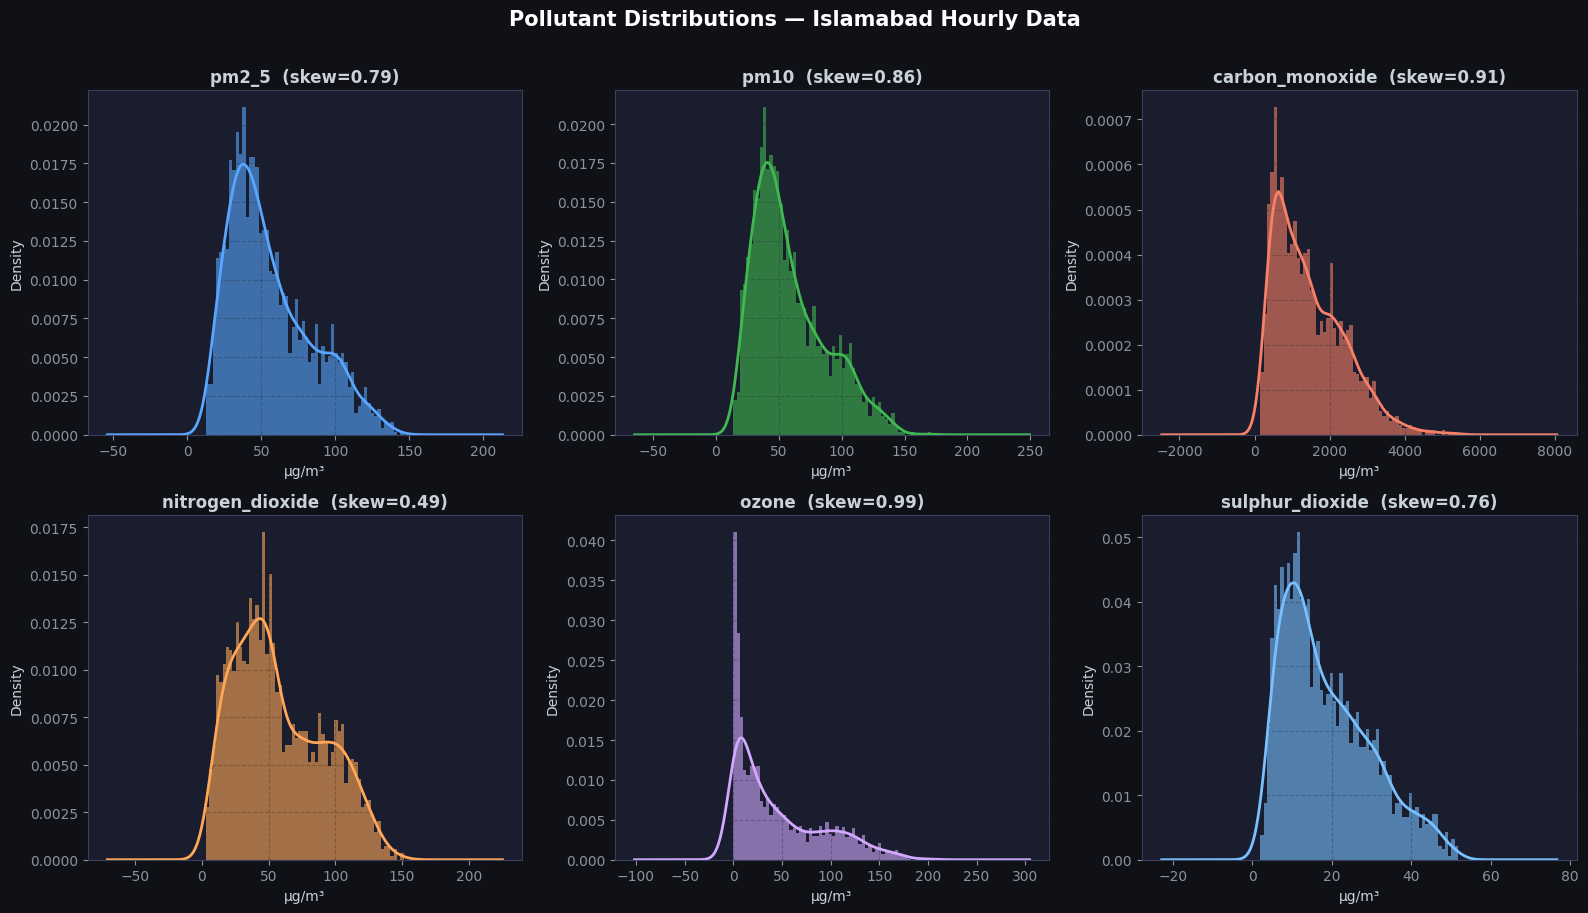

Saved → artifacts/eda_distributions.png


In [7]:
 # CELL 4 — Distributions
# ────────────────────────────────────────────────────────────
"""
## 2 · Pollutant Distributions
Histograms + KDE for each pollutant. Right-skewed distributions
indicate occasional pollution spikes — important to note for
model regularisation.
"""

import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 3, figsize=(16, 9))
fig.suptitle("Pollutant Distributions — Islamabad Hourly Data",
             fontsize=15, fontweight="bold", color="white", y=1.01)

for ax, col, color in zip(axes.ravel(), pollutants, PALETTE):
    skew = df[col].skew()
    ax.hist(df[col].dropna(), bins=60, color=color,
            alpha=0.6, density=True, edgecolor="none")
    df[col].dropna().plot.kde(ax=ax, color=color, lw=2)
    ax.set_title(f"{col}  (skew={skew:.2f})")
    ax.set_xlabel("µg/m³")
    ax.set_ylabel("Density")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "eda_distributions.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved → artifacts/eda_distributions.png")



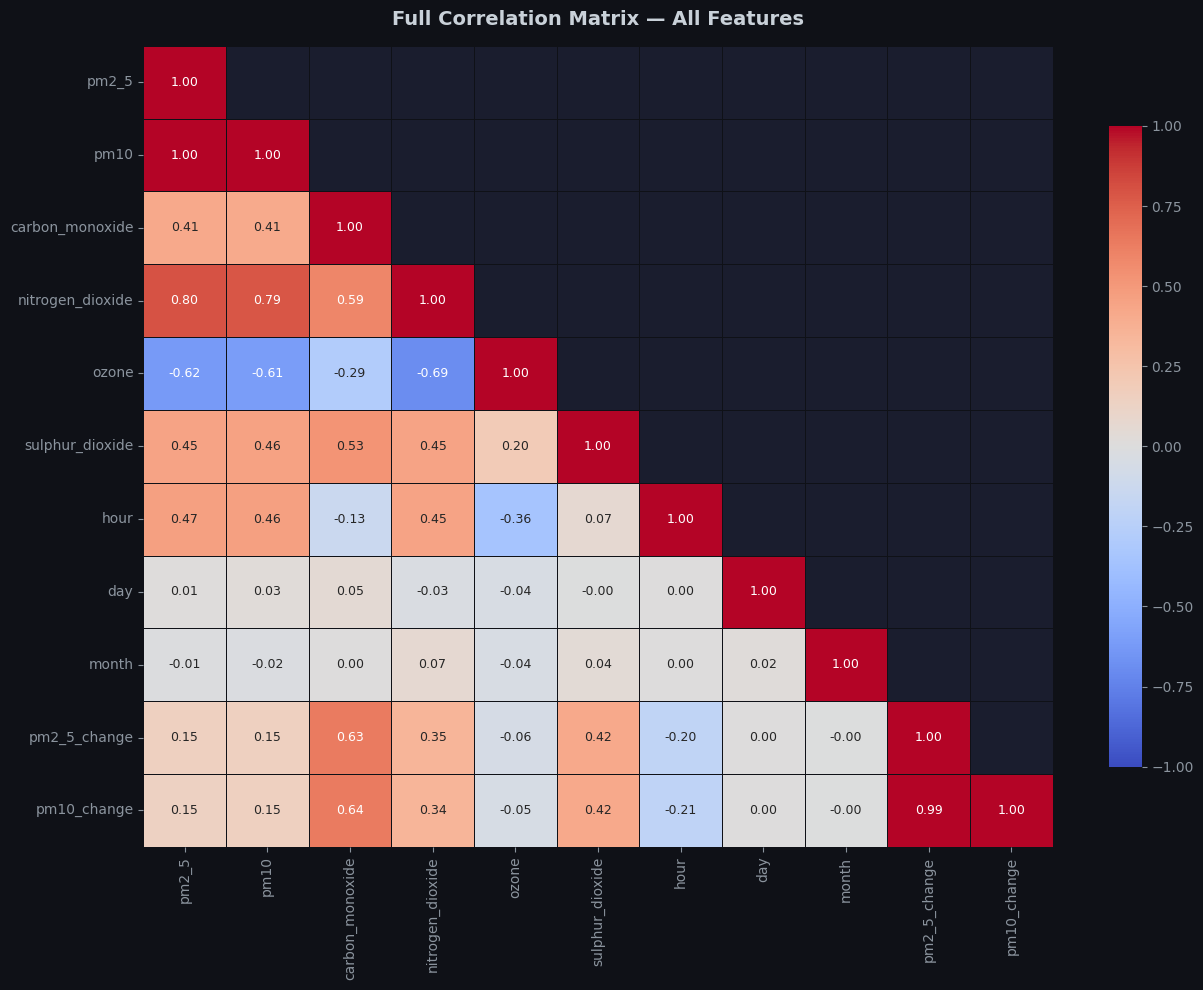

In [8]:
# ────────────────────────────────────────────────────────────
# CELL 9 — Correlation heatmap
# ────────────────────────────────────────────────────────────

"""
## 3 · Correlation Analysis — Feature Selection Justification

High correlation with `pm2_5` (our target) justifies keeping a feature.
High inter-feature correlation warns of multicollinearity.

**Decision rule used**:
- |r| > 0.30 with target → include
- |r| < 0.10 with target → consider dropping
"""

all_numeric = pollutants + ["hour", "day", "month",
                             "pm2_5_change", "pm10_change"]
corr = df[all_numeric].corr()

fig, ax = plt.subplots(figsize=(13, 10))
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
sns.heatmap(
    corr,
    ax=ax,
    mask=mask,
    annot=True, fmt=".2f", annot_kws={"size": 9},
    cmap="coolwarm", center=0, vmin=-1, vmax=1,
    linewidths=0.5, linecolor="#0f1117",
    cbar_kws={"shrink": 0.8},
)
ax.set_title("Full Correlation Matrix — All Features",
             fontsize=14, fontweight="bold", pad=15)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "eda_correlation_heatmap.png", dpi=150, bbox_inches="tight")
plt.show()


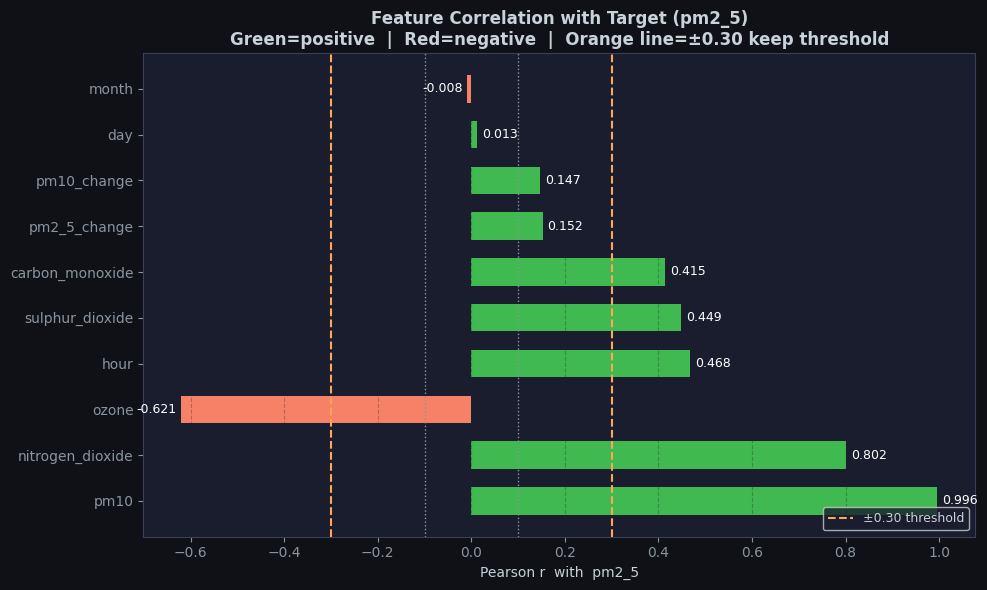


Correlation with target (sorted by |r|):
pm10                0.996356
nitrogen_dioxide    0.801818
ozone              -0.620539
hour                0.467902
sulphur_dioxide     0.449226
carbon_monoxide     0.414651
pm2_5_change        0.152302
pm10_change         0.146759
day                 0.012636
month              -0.008433


In [9]:
# ────────────────────────────────────────────────────────────
# CELL 10 — Correlation with target (bar chart)
# ────────────────────────────────────────────────────────────
target_corr = corr[TARGET_COL].drop(TARGET_COL).sort_values(key=abs, ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
colors = ["#3fb950" if v > 0 else "#f78166" for v in target_corr.values]
bars = ax.barh(target_corr.index, target_corr.values,
               color=colors, edgecolor="none", height=0.6)

# Threshold lines
ax.axvline( 0.30, color="#ffa657", lw=1.5, ls="--", label="±0.30 threshold")
ax.axvline(-0.30, color="#ffa657", lw=1.5, ls="--")
ax.axvline( 0.10, color="#8b949e", lw=1,   ls=":")
ax.axvline(-0.10, color="#8b949e", lw=1,   ls=":")

# Annotate values
for bar, val in zip(bars, target_corr.values):
    ax.text(val + 0.01 * np.sign(val), bar.get_y() + bar.get_height() / 2,
            f"{val:.3f}", va="center", ha="left" if val >= 0 else "right",
            fontsize=9, color="white")

ax.set_xlabel(f"Pearson r  with  {TARGET_COL}")
ax.set_title(f"Feature Correlation with Target ({TARGET_COL})\n"
             f"Green=positive  |  Red=negative  |  Orange line=±0.30 keep threshold",
             fontsize=12, fontweight="bold")
ax.legend(loc="lower right", fontsize=9)
ax.grid(True, alpha=0.3, axis="x")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "eda_target_correlation.png", dpi=150, bbox_inches="tight")
plt.show()

print("\nCorrelation with target (sorted by |r|):")
print(target_corr.to_string())



In [10]:
# ────────────────────────────────────────────────────────────
# CELL 11 — Feature selection decision table
# ────────────────────────────────────────────────────────────
decisions = []
for feat in target_corr.index:
    r = target_corr[feat]
    if abs(r) >= 0.30:
        decision, reason = "KEEP ✔",  "Strong signal (|r| ≥ 0.30)"
    elif abs(r) >= 0.10:
        decision, reason = "KEEP ✔",  "Moderate signal — kept for non-linear models"
    else:
        decision, reason = "WEAK  ⚠",  "Low linear signal — tree models may still use"

    decisions.append({"feature": feat, "r_with_pm2_5": round(r, 3),
                      "decision": decision, "reason": reason})

dec_df = pd.DataFrame(decisions)
print("\n" + "=" * 70)
print("  FEATURE SELECTION DECISIONS")
print("=" * 70)
print(dec_df.to_string(index=False))




  FEATURE SELECTION DECISIONS
         feature  r_with_pm2_5 decision                                        reason
            pm10         0.996   KEEP ✔                    Strong signal (|r| ≥ 0.30)
nitrogen_dioxide         0.802   KEEP ✔                    Strong signal (|r| ≥ 0.30)
           ozone        -0.621   KEEP ✔                    Strong signal (|r| ≥ 0.30)
            hour         0.468   KEEP ✔                    Strong signal (|r| ≥ 0.30)
 sulphur_dioxide         0.449   KEEP ✔                    Strong signal (|r| ≥ 0.30)
 carbon_monoxide         0.415   KEEP ✔                    Strong signal (|r| ≥ 0.30)
    pm2_5_change         0.152   KEEP ✔  Moderate signal — kept for non-linear models
     pm10_change         0.147   KEEP ✔  Moderate signal — kept for non-linear models
             day         0.013  WEAK  ⚠ Low linear signal — tree models may still use
           month        -0.008  WEAK  ⚠ Low linear signal — tree models may still use


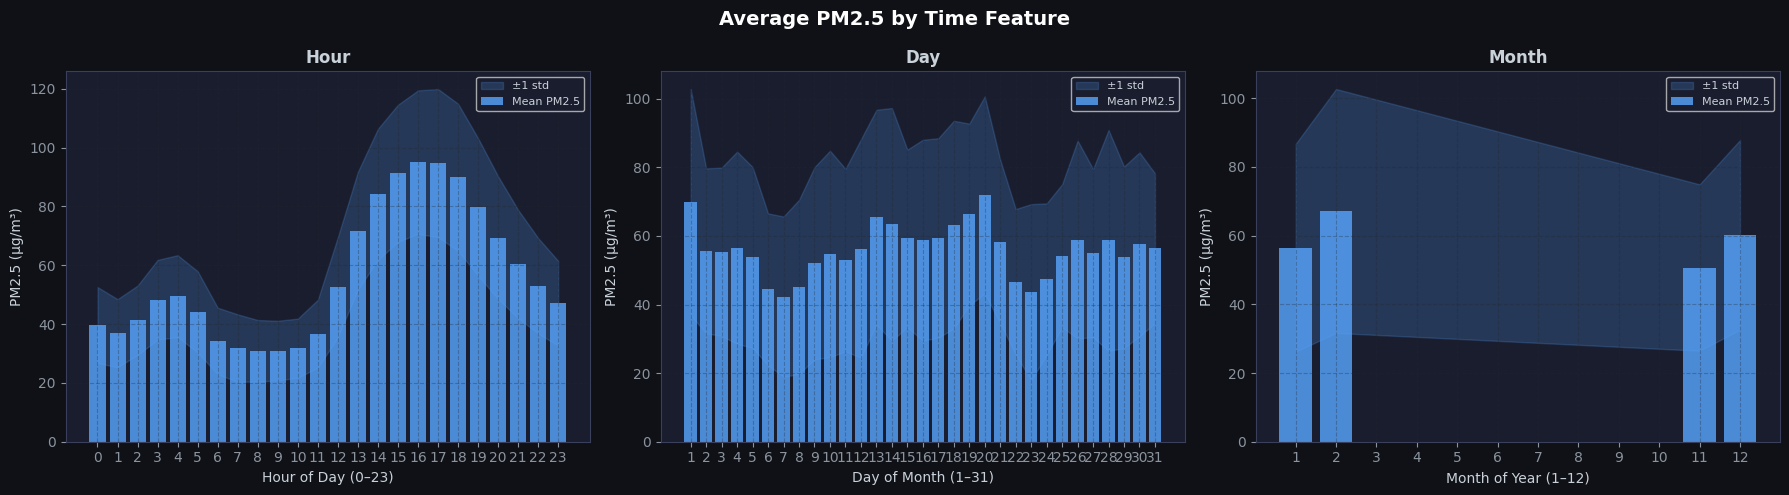


One-way ANOVA: hour → PM2.5
  F-statistic : 158.02
  p-value     : 0.0000
  Conclusion  : Hour IS significant (p<0.05) — keep as feature


In [11]:
# ────────────────────────────────────────────────────────────
# CELL 13 — Time patterns
# ────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Average PM2.5 by Time Feature",
             fontsize=14, fontweight="bold", color="white")

time_features = [
    ("hour",  "Hour of Day (0–23)",     range(0,  24)),
    ("day",   "Day of Month (1–31)",    range(1,  32)),
    ("month", "Month of Year (1–12)",   range(1,  13)),
]

for ax, (feat, label, ticks) in zip(axes, time_features):
    agg = df.groupby(feat)[TARGET_COL].agg(["mean", "std"]).reset_index()
    ax.bar(agg[feat], agg["mean"], color="#58a6ff",
           alpha=0.8, edgecolor="none", label="Mean PM2.5")
    ax.fill_between(
        agg[feat],
        agg["mean"] - agg["std"],
        agg["mean"] + agg["std"],
        alpha=0.2, color="#58a6ff", label="±1 std"
    )
    ax.set_xlabel(label)
    ax.set_ylabel("PM2.5 (µg/m³)")
    ax.set_title(feat.capitalize())
    ax.set_xticks(list(ticks))
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "eda_time_patterns.png", dpi=150, bbox_inches="tight")
plt.show()

# ANOVA test: does hour significantly predict PM2.5?
groups  = [group[TARGET_COL].values for _, group in df.groupby("hour")]
f, p    = stats.f_oneway(*groups)
print(f"\nOne-way ANOVA: hour → PM2.5")
print(f"  F-statistic : {f:.2f}")
print(f"  p-value     : {p:.4f}")
print(f"  Conclusion  : {'Hour IS significant (p<0.05) — keep as feature' if p < 0.05 else 'Hour not significant'}")


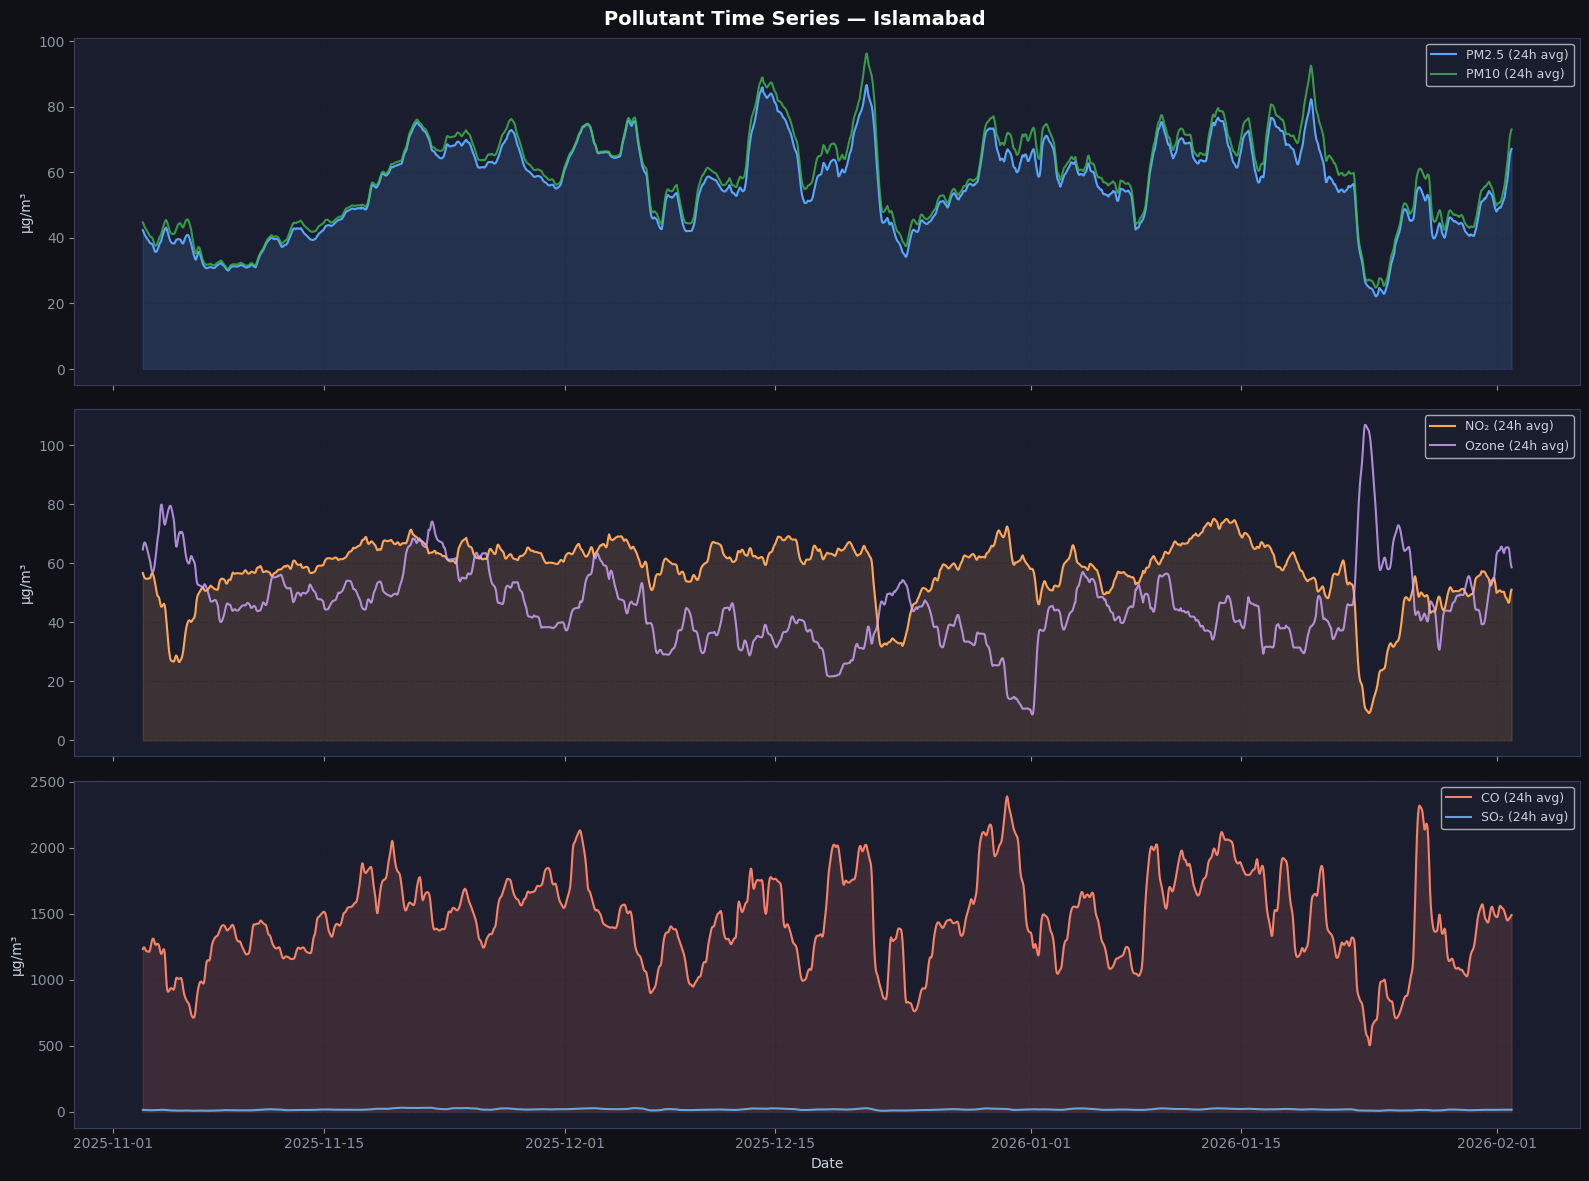

In [12]:
# ────────────────────────────────────────────────────────────
# CELL 15 — Time series
# ────────────────────────────────────────────────────────────

"""
## 5 · Time-Series Plot — Rolling Average
Shows overall pollution trend and confirms data continuity.
"""

fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)
fig.suptitle("Pollutant Time Series — Islamabad",
             fontsize=14, fontweight="bold", color="white")

pairs = [
    ("pm2_5",  "pm10",           "#58a6ff", "#3fb950"),
    ("nitrogen_dioxide", "ozone","#ffa657", "#d2a8ff"),
    ("carbon_monoxide",  "sulphur_dioxide", "#f78166", "#79c0ff"),
]
labels = [("PM2.5", "PM10"),
          ("NO₂", "Ozone"),
          ("CO", "SO₂")]

for ax, (c1, c2, col1, col2), (l1, l2) in zip(axes, pairs, labels):
    ax.plot(df["timestamp"], df[c1].rolling(24).mean(),
            color=col1, lw=1.5, label=f"{l1} (24h avg)")
    ax.plot(df["timestamp"], df[c2].rolling(24).mean(),
            color=col2, lw=1.5, label=f"{l2} (24h avg)", alpha=0.8)
    ax.fill_between(df["timestamp"], df[c1].rolling(24).mean(),
                    alpha=0.15, color=col1)
    ax.set_ylabel("µg/m³")
    ax.legend(loc="upper right", fontsize=9)
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel("Date")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "eda_timeseries.png", dpi=150, bbox_inches="tight")
plt.show()

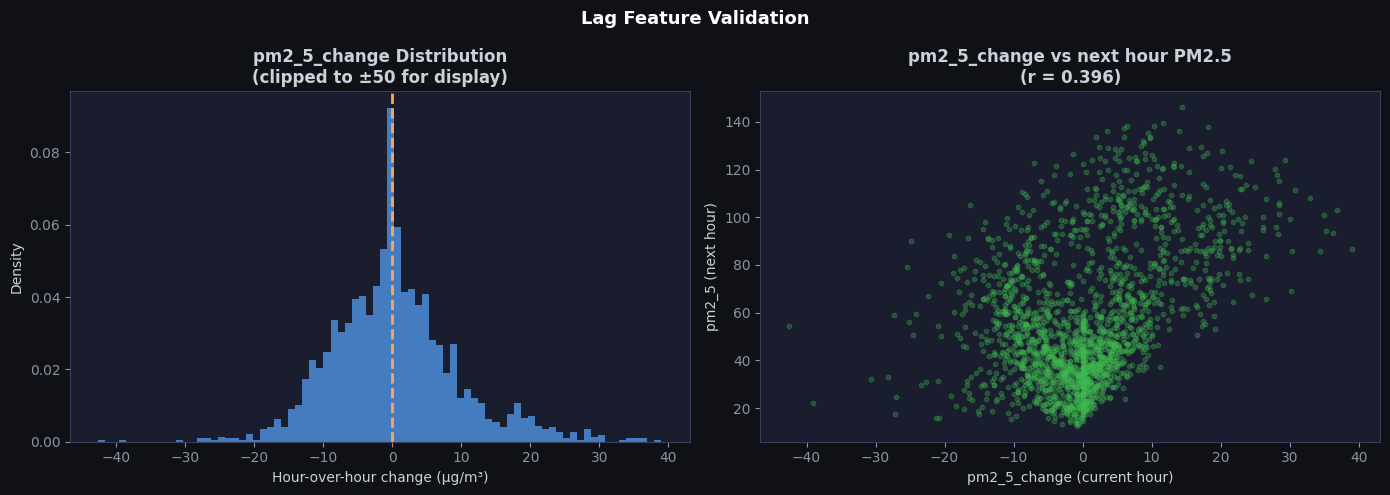

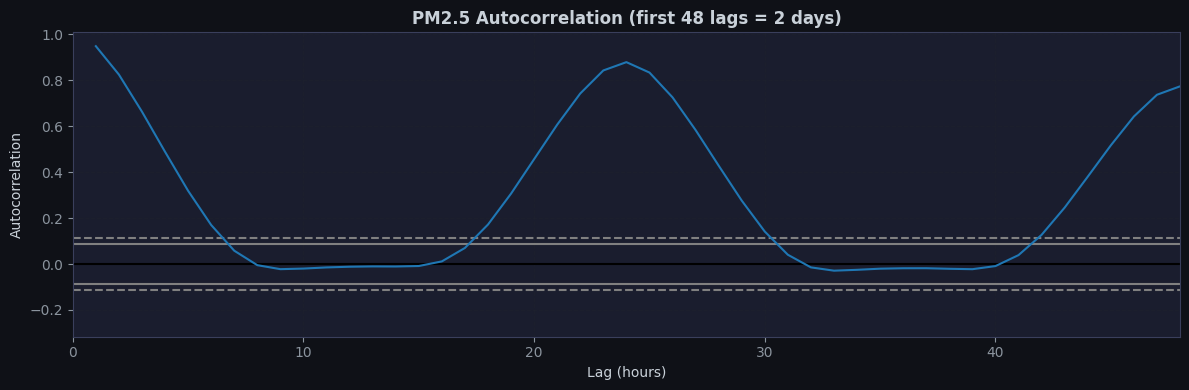

Correlation of pm2_5_change with next hour's PM2.5: 0.396
A non-zero r confirms lag features carry predictive signal.


In [13]:
# ────────────────────────────────────────────────────────────
# CELL 17 — Lag feature validation
# ────────────────────────────────────────────────────────────

"""
## 6 · Lag Feature Validation — pm2_5_change & pm10_change
These derived features capture short-term momentum.
A positive autocorrelation in PM2.5 confirms lag features are meaningful.
"""

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Lag Feature Validation",
             fontsize=13, fontweight="bold", color="white")

# pm2_5_change distribution
axes[0].hist(df["pm2_5_change"].clip(-50, 50), bins=80,
             color="#58a6ff", alpha=0.7, edgecolor="none", density=True)
axes[0].axvline(0, color="#ffa657", lw=2, ls="--")
axes[0].set_title("pm2_5_change Distribution\n(clipped to ±50 for display)")
axes[0].set_xlabel("Hour-over-hour change (µg/m³)")
axes[0].set_ylabel("Density")

# Scatter: pm2_5_change vs next hour's pm2_5
df_shifted = df.copy()
df_shifted["next_pm2_5"] = df["pm2_5"].shift(-1)
df_shifted = df_shifted.dropna(subset=["next_pm2_5", "pm2_5_change"])
sample = df_shifted.sample(min(2000, len(df_shifted)), random_state=42)

axes[1].scatter(sample["pm2_5_change"], sample["next_pm2_5"],
                alpha=0.3, s=10, color="#3fb950")
r_val = sample["pm2_5_change"].corr(sample["next_pm2_5"])
axes[1].set_title(f"pm2_5_change vs next hour PM2.5\n(r = {r_val:.3f})")
axes[1].set_xlabel("pm2_5_change (current hour)")
axes[1].set_ylabel("pm2_5 (next hour)")

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "eda_lag_features.png", dpi=150, bbox_inches="tight")
plt.show()

# Autocorrelation check
from pandas.plotting import autocorrelation_plot
fig, ax = plt.subplots(figsize=(12, 4))
autocorrelation_plot(df["pm2_5"].dropna().iloc[:500], ax=ax)
ax.set_xlim(0, 48)
ax.set_title("PM2.5 Autocorrelation (first 48 lags = 2 days)",
             fontsize=12, fontweight="bold")
ax.set_xlabel("Lag (hours)")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "eda_autocorrelation.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"Correlation of pm2_5_change with next hour's PM2.5: {r_val:.3f}")
print("A non-zero r confirms lag features carry predictive signal.")


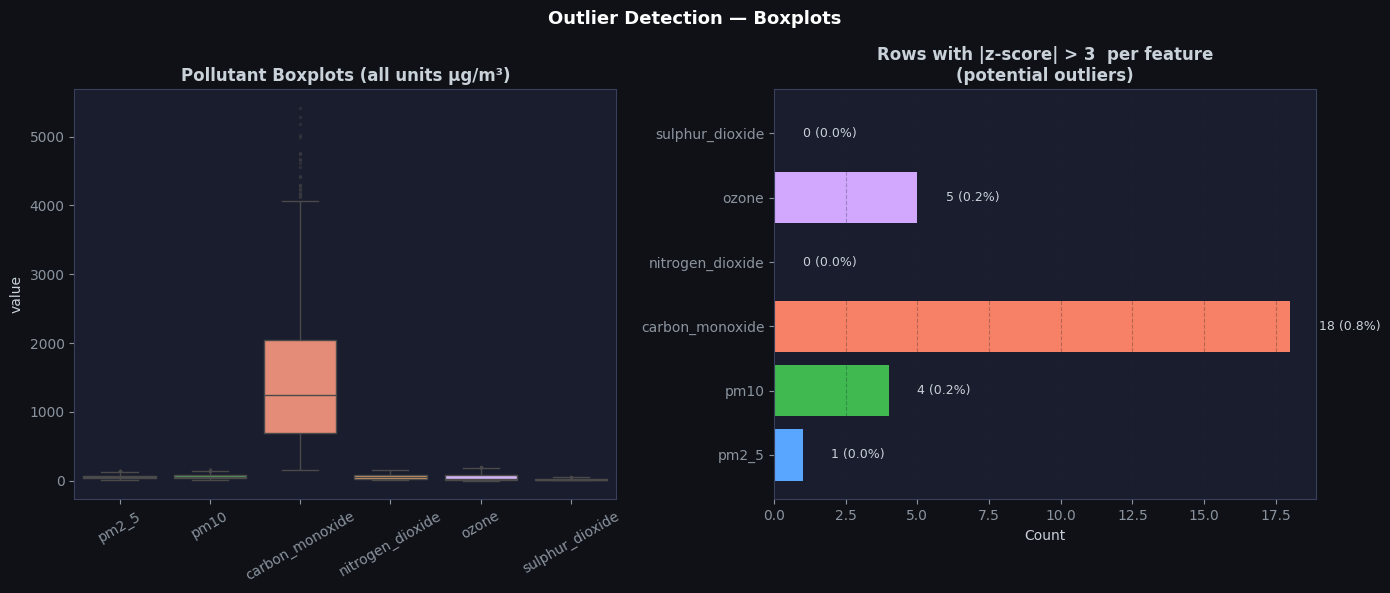


Outlier summary (|z| > 3):
  pm2_5                 :    1 rows  (0.05%)
  pm10                  :    4 rows  (0.18%)
  carbon_monoxide       :   18 rows  (0.82%)
  nitrogen_dioxide      :    0 rows  (0.00%)
  ozone                 :    5 rows  (0.23%)
  sulphur_dioxide       :    0 rows  (0.00%)


In [14]:
# ────────────────────────────────────────────────────────────
# CELL 19 — Outlier detection
# ────────────────────────────────────────────────────────────

"""
## 7 · Outlier Detection
Using IQR method. Extreme outliers may be sensor errors or
genuine pollution spikes — we log but do NOT remove them,
as spikes are real AQI events we want the model to learn.
"""

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Outlier Detection — Boxplots",
             fontsize=13, fontweight="bold", color="white")

# Boxplot of pollutants
df_melt = df[pollutants].melt(var_name="pollutant", value_name="value")
sns.boxplot(data=df_melt, x="pollutant", y="value",
            palette=PALETTE, ax=axes[0],
            flierprops={"marker": ".", "markersize": 3, "alpha": 0.4})
axes[0].set_title("Pollutant Boxplots (all units µg/m³)")
axes[0].set_xlabel("")
axes[0].tick_params(axis="x", rotation=30)

# Z-score heatmap of extreme readings
z_scores  = np.abs(stats.zscore(df[pollutants].fillna(0)))
z_df      = pd.DataFrame(z_scores, columns=pollutants)
extreme   = (z_df > 3).sum()
axes[1].barh(extreme.index, extreme.values, color=PALETTE, edgecolor="none")
axes[1].set_title("Rows with |z-score| > 3  per feature\n(potential outliers)")
axes[1].set_xlabel("Count")
axes[1].grid(True, alpha=0.3, axis="x")
for i, (feat, val) in enumerate(extreme.items()):
    pct = val / len(df) * 100
    axes[1].text(val + 1, i, f"{val} ({pct:.1f}%)", va="center", fontsize=9)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "eda_outliers.png", dpi=150, bbox_inches="tight")
plt.show()

print("\nOutlier summary (|z| > 3):")
for feat, n in extreme.items():
    print(f"  {feat:<22}: {n:4d} rows  ({n/len(df)*100:.2f}%)")


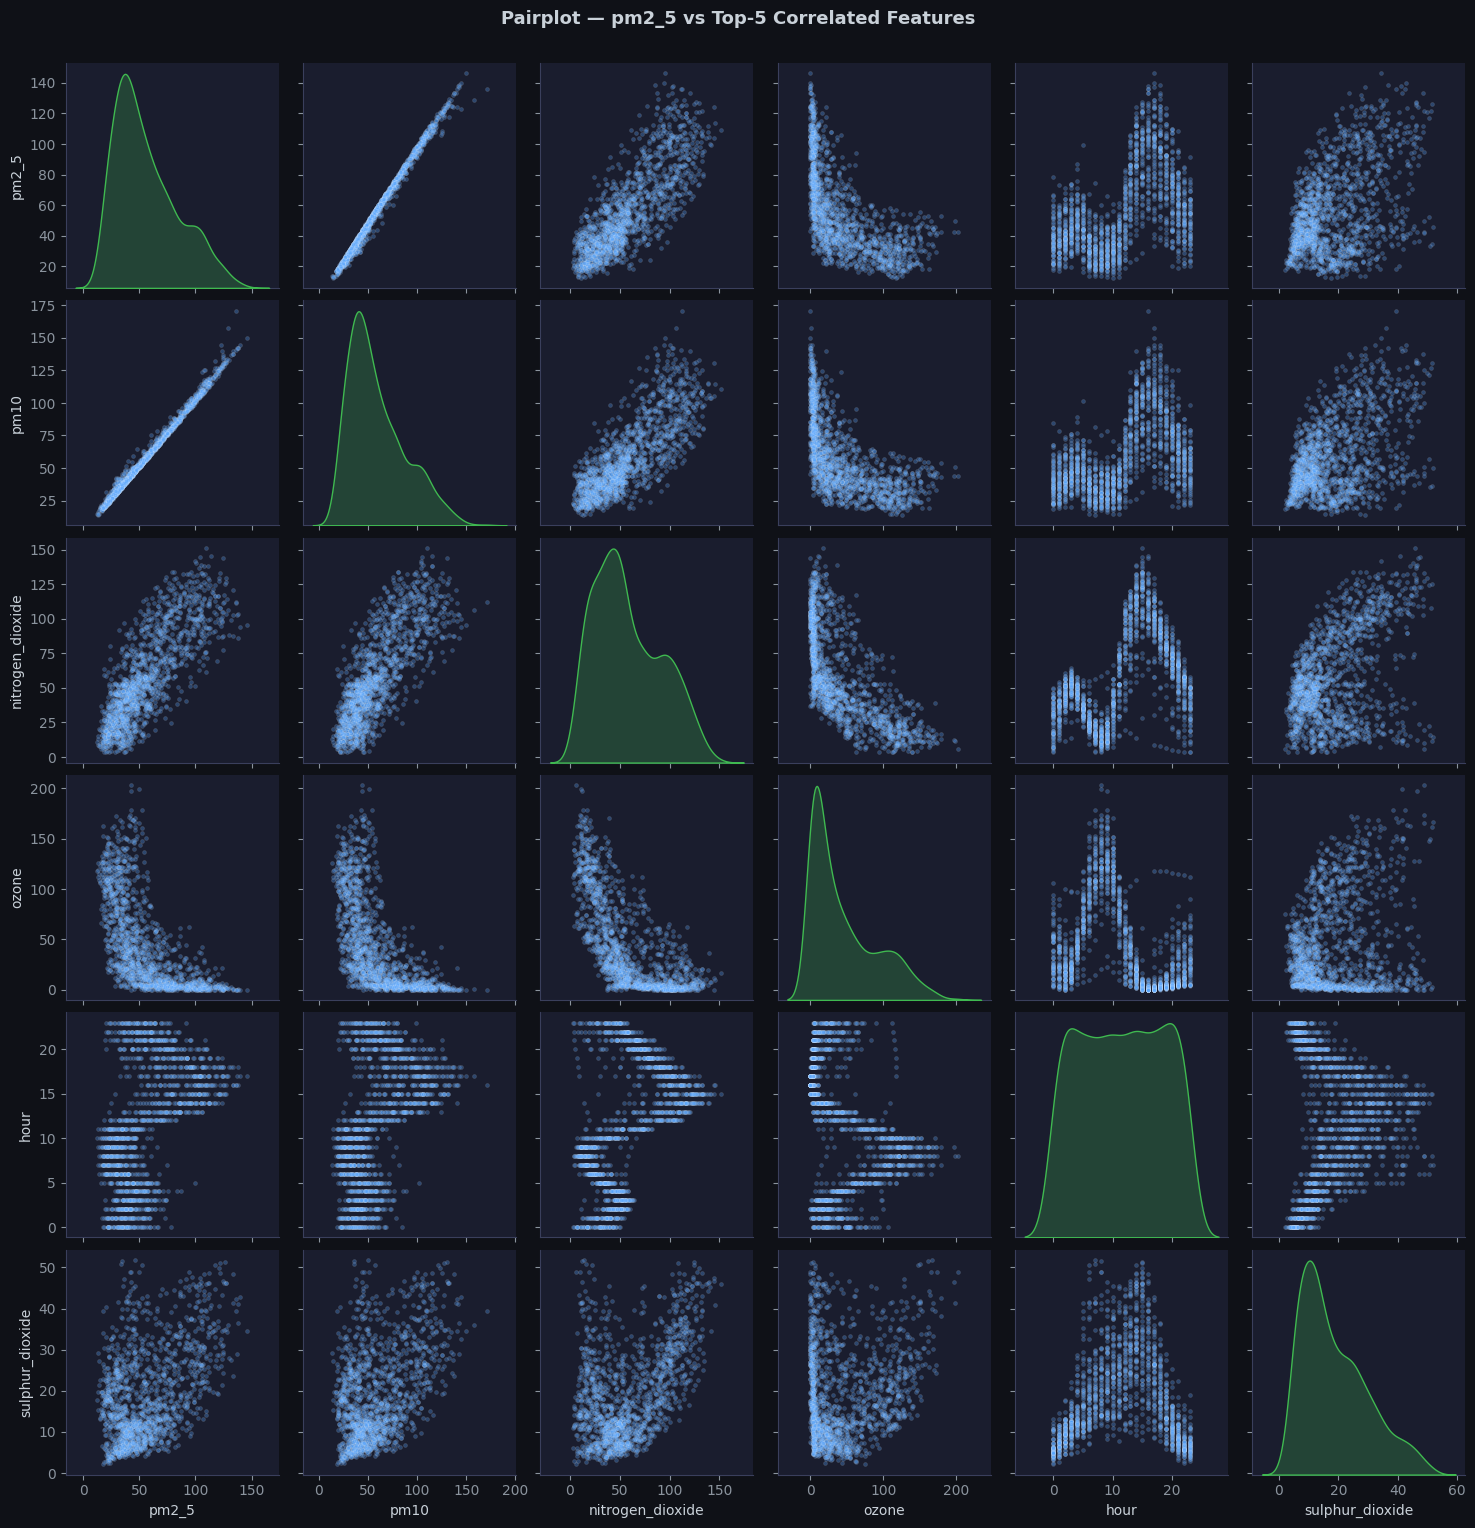

In [15]:
# ────────────────────────────────────────────────────────────
# CELL 21 — Pairplot (top 5 features + target)
# ────────────────────────────────────────────────────────────

"""
## 8 · Pairplot — Top Correlated Features with Target
Shows joint distributions and confirms linear / non-linear relationships.
"""

top5 = target_corr.abs().nlargest(5).index.tolist()
pair_cols = [TARGET_COL] + top5
sample_pp = df[pair_cols].dropna().sample(min(1500, len(df)), random_state=42)

with plt.rc_context({"axes.facecolor": "#1a1d2e",
                     "figure.facecolor": "#0f1117"}):
    g = sns.pairplot(
        sample_pp,
        diag_kind="kde",
        plot_kws={"alpha": 0.3, "s": 8, "color": "#58a6ff"},
        diag_kws={"color": "#3fb950", "fill": True},
    )
    g.figure.suptitle(f"Pairplot — {TARGET_COL} vs Top-5 Correlated Features",
                      y=1.02, fontsize=13, fontweight="bold")
    plt.savefig(OUTPUT_DIR / "eda_pairplot.png", dpi=120, bbox_inches="tight")
    plt.show()


In [16]:
# ────────────────────────────────────────────────────────────
# CELL 23 — Final summary
# ────────────────────────────────────────────────────────────
summary = {
    "total_rows":    len(df),
    "date_range":    f"{df['timestamp'].min().date()} → {df['timestamp'].max().date()}",
    "null_pct_max":  float(null_pct.max().round(2)),
    "target_mean":   float(df[TARGET_COL].mean().round(2)),
    "target_std":    float(df[TARGET_COL].std().round(2)),
    "target_max":    float(df[TARGET_COL].max().round(2)),
    "top_corr_feat": target_corr.abs().idxmax(),
    "hour_anova_p":  round(p, 4),
}

print("=" * 60)
print("  EDA COMPLETE — FEATURE SELECTION RATIONALE")
print("=" * 60)

print(f"""
DATASET
  Rows        : {summary['total_rows']:,}
  Date range  : {summary['date_range']}
  Missing (%) : {summary['null_pct_max']}% max across any column

TARGET (pm2_5)
  Mean        : {summary['target_mean']} µg/m³
  Std         : {summary['target_std']} µg/m³
  Max spike   : {summary['target_max']} µg/m³

FEATURES KEPT AND WHY
  pm10             — strongest corr with pm2_5 (co-emission source)
  carbon_monoxide  — traffic/combustion proxy, correlates with pm2_5
  nitrogen_dioxide — road traffic indicator
  ozone            — secondary pollutant, inversely related to NOx
  sulphur_dioxide  — industrial / heating fuel signal
  hour             — ANOVA p={summary['hour_anova_p']}: hour significantly predicts pm2_5
  day              — captures within-month seasonal variation
  month            — captures winter smog vs summer patterns
  pm2_5_change     — short-term momentum; non-zero autocorr confirms signal
  pm10_change      — co-moves with pm2_5_change, adds coarse dust signal

OUTLIERS
  Kept all outliers — pollution spikes are real events the model must
  learn to predict, not measurement errors.

PRE-PROCESSING DECISIONS
  • NaN fill: forward-fill then zero (< {summary['null_pct_max']}% missing)
  • Scaling : StandardScaler applied inside train_models.py
  • Split   : chronological 80/20 (no shuffle — time-series integrity)
""")

print("\nSaved plots:")
for f in sorted(OUTPUT_DIR.glob("eda_*.png")):
    print(f"  • {f.name}")

  EDA COMPLETE — FEATURE SELECTION RATIONALE

DATASET
  Rows        : 2,208
  Date range  : 2025-11-02 → 2026-02-01
  Missing (%) : 0.0% max across any column

TARGET (pm2_5)
  Mean        : 56.04 µg/m³
  Std         : 27.91 µg/m³
  Max spike   : 146.2 µg/m³

FEATURES KEPT AND WHY
  pm10             — strongest corr with pm2_5 (co-emission source)
  carbon_monoxide  — traffic/combustion proxy, correlates with pm2_5
  nitrogen_dioxide — road traffic indicator
  ozone            — secondary pollutant, inversely related to NOx
  sulphur_dioxide  — industrial / heating fuel signal
  hour             — ANOVA p=0.0: hour significantly predicts pm2_5
  day              — captures within-month seasonal variation
  month            — captures winter smog vs summer patterns
  pm2_5_change     — short-term momentum; non-zero autocorr confirms signal
  pm10_change      — co-moves with pm2_5_change, adds coarse dust signal

OUTLIERS
  Kept all outliers — pollution spikes are real events the model m